# BoltzRank #
## Luca Negrini - Mat. 956516 ##
### From "BoltzRank: Learning to Maximize Expected Ranking Gain" ###
#### Maxims M. Volkovs, Richard S. Zemel ####

------
#### Initialization ####

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#%matplotlib notebook

%load_ext cython

# install lightgbm (required only on first run)
# import sys
# !{sys.executable} -m pip install lightgbm

import os
import os.path
import numpy as np
import lightgbm
import matplotlib.pyplot as plt

# see http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_svmlight_file.html
from sklearn.datasets import load_svmlight_file 

# datasets available at: 
# https://www.microsoft.com/en-us/research/project/mslr/
DATASET_FOLDER = "C:/opt/kiis-training/MSLR-WEB10K/Fold1/"
PERM_FOLDER = DATASET_FOLDER + "perms/"
METRIC_NAME = 'ndcg@10'#'BoltzRank-NDCG@10'

-----
#### Data loading ####

In [2]:
def ensureFile(path):
    if not os.path.exists(path) or not os.path.isfile(path):
        raise FileNotFoundError("'" + path + "': no such file")        
    return path

def retrieveFileNames():
    folder = DATASET_FOLDER + '/' if DATASET_FOLDER[-1:] != '/' else DATASET_FOLDER
    train_file = ensureFile(folder + "train.txt")
    valid_file = ensureFile(folder + "vali.txt")
    test_file = ensureFile(folder + "test.txt")
    return train_file, valid_file, test_file

def loadDataset(path):
    return load_svmlight_file(path, query_id=True)

def loadLightGBM(svmlight_dataset):
    query_lens = [sum(1 for _ in group) for key, group in itertools.groupby(svmlight_dataset[2])]
    return lightgbm.Dataset(data=svmlight_dataset[0], label=svmlight_dataset[1], group=query_lens)

In [3]:
class Query:
    def __init__(self, qid):
        self.qid = qid
        self.labels_to_docs = {}
    def addlabel(self, label):
        if not label in self.labels_to_docs:
            self.labels_to_docs[label] = list()
    def adddoc(self, label, doc):
        self.labels_to_docs[label].append(doc)
    def finalize(self, alllabels):
        self.labels = np.zeros(len(self.labels_to_docs.keys()), dtype=int)
        self.docs = np.empty(len(self.labels_to_docs.keys()), dtype=object)
        i = 0
        totaldocs = 0
        sorteddict = sorted(self.labels_to_docs.items(), reverse = True)
        for label, docs in sorteddict:
            self.labels[i] = label
            self.docs[i] = np.zeros(len(docs), dtype=int)
            for j in range(len(docs)):
                self.docs[i][j] = docs[j]
            i += 1
            totaldocs += len(docs)
        self.alldocs = np.concatenate(self.docs)
        self.flatlabels = np.zeros(totaldocs, dtype=np.double)
        i = 0
        for label, docs in sorteddict:
            for j in range(len(docs)):
                self.flatlabels[i] = label
                i += 1       
        k = min(10, len(self.alldocs))
        self.idealdcg = dcg_k(self.alldocs, alllabels, k) 
        del self.labels_to_docs
    def setperms(self, perms):
        self.perms = perms
    def setprobs(self, probs):
        self.probs = probs
    def setndcgs(self, ndcgs):
        self.ndcgs = ndcgs
    def __repr__(self):  
        return str(self)
    def __str__(self):
        res = "Query " + str(self.qid) + "["
        res += "\nideal dcg: " + str(self.idealdcg)
        for i in range(len(self.labels)):
            res += "\n" + str(self.labels[i]) + " -> " + str(self.docs[i])
        res += "]"
        if hasattr(self, 'perms'):
            for i in range(len(self.perms)):
                res += "\n[" + str(self.perms[i]) + "] -> p: " + str(self.probs[i]) + ", dcg: " + str(self.ndcgs[i])
        else:
            res += "\nNo permutations computed yet"
        return res

In [4]:
# parameters:
#  dataset: svmlight_dataset 
#      the datset to process
# returned values:
#  query_to_labels_to_documents: dict(int -> dict(float -> list(int)))
#      a map containing, for each query in the dataset, the documents (row index in the dataset) provided 
#      in the input dataset grouped by label
#  doc_to_query: dict(document -> query)
#      a mapping between document (row index in the dataset) and the relative query
def mapQueryToDocuments(dataset):
    queries = {}
    alllabels = np.negative(np.ones(len(dataset[2]), dtype=np.double))
    for i in range(0, len(dataset[2])):
        if not dataset[2][i] in queries:
            queries[dataset[2][i]] = Query(dataset[2][i])
        query = queries[dataset[2][i]]
        query.addlabel(dataset[1][i])
        query.adddoc(dataset[1][i], i)
        alllabels[i] = dataset[1][i]
        
    for q in queries.values():
        q.finalize(alllabels)
    
    return queries, alllabels

-----
#### BoltzRank logic in Cython ####

In [5]:
%%cython 
from libc.math cimport exp
from cython.parallel import prange
from cython import boundscheck, wraparound
from libc.math cimport log, log2
from math import factorial
import numpy as np
import random
import itertools
from libc.stdio cimport printf

###############################################################################################################
###############################################################################################################
#                                              NDCG EVALUATION
###############################################################################################################
###############################################################################################################

@boundscheck(False)
@wraparound(False)
cpdef double dcg_k(int[:] rank, double[:] scores, int k) nogil:
    cdef double result = 0
    cdef int i
    for i in prange(k, schedule='static', num_threads=8):
        result += (2**scores[rank[i]] - 1) / (log2(i + 2)) # should be i+1, but with numbering starting from 1 instead of 0
    return result


@boundscheck(False)
@wraparound(False)
cdef double ndcg_k(int[:] rank, double[:] scores, int k, double ideal) nogil:
    if ideal == 0:
        return 1.0
    return dcg_k(rank, scores, k) / ideal

###############################################################################################################
###############################################################################################################
#                                          PERMUTATIONS GENERATION
###############################################################################################################
###############################################################################################################

RANK_SAMPLE_SET_MAX_QUERY_PERMUTATIONS = 100
RANK_SAMPLE_SET_DISTRIBUTIONS = [
                                int(.30 * RANK_SAMPLE_SET_MAX_QUERY_PERMUTATIONS), # 4->0
                                int(.22 * RANK_SAMPLE_SET_MAX_QUERY_PERMUTATIONS), # 4->1
                                int(.18 * RANK_SAMPLE_SET_MAX_QUERY_PERMUTATIONS), # 4->2
                                int(.12 * RANK_SAMPLE_SET_MAX_QUERY_PERMUTATIONS), # 4->3
                                int(.10 * RANK_SAMPLE_SET_MAX_QUERY_PERMUTATIONS), # 3->0
                                int(.06 * RANK_SAMPLE_SET_MAX_QUERY_PERMUTATIONS), # 3->1
                                int(.02 * RANK_SAMPLE_SET_MAX_QUERY_PERMUTATIONS), # 3->2
                                int(.0 * RANK_SAMPLE_SET_MAX_QUERY_PERMUTATIONS), # 2->0
                                int(.0 * RANK_SAMPLE_SET_MAX_QUERY_PERMUTATIONS), # 2->1
                                int(.0 * RANK_SAMPLE_SET_MAX_QUERY_PERMUTATIONS)  # 1->0
                                ]

@boundscheck(False)
@wraparound(False)
cdef bint contained(int[:,:] container, int[:] array) nogil:
    cdef bint match
    cdef int i
    cdef int j
    for i in prange(len(container), schedule='static', num_threads=8):
        if container[i][0] == -1 or len(container[i]) != len(array):
            continue
        else:
            match = True
            for j in range(len(container[i])):
                if container[i][j] != array[j]:
                    match = False
                    break
            if match:
                return True
    return False

@boundscheck(False)
@wraparound(False)
cdef void setrow(int[:,:] container, int pos, int[:] array) nogil:
    cdef int i
    for i in prange(len(container[pos]), schedule='static', num_threads=8):
        container[pos][i] = array[i]

@boundscheck(False)
@wraparound(False)
cdef int[:,:] allPerms(int[:] source, long long fact):
    cdef int i = 0
    cdef int k
    perm = itertools.permutations(source)
    cdef int[:,:] result = np.zeros((fact, len(source)), dtype=int)
    for p in perm:
        for k in range(len(p)):
            result[i][k] = p[k]
        i += 1
    return result

#source: label -> docid*, i: int, j: int, count: int, perms_with_prob: tuple<int> -> float
#return: number of not computed permutations
@boundscheck(False)
@wraparound(False)
def perform_permutation(query, int i, int j, int count, int[:,:] perms, int start):
    if not i in query.labels or not j in query.labels:
        # no swapping possible
        return count, start
    # find the indexes of the desired labels
    i = [k for k in range(len(query.labels)) if query.labels[k] == i][0]
    j = [k for k in range(len(query.labels)) if query.labels[k] == j][0]
    cdef int c = 0
    cdef int _min = min(len(query.docs[i]), len(query.docs[j]))
    cdef int amount = max(1, int(_min * .5))
    limit = factorial(_min) / (factorial(amount) * factorial(_min - amount))
    cdef int k
    cdef int d
    for k in range(count):
        perm = query.docs.copy()
        first = random.sample(range(len(query.docs[i])), k=amount)
        second = random.sample(range(len(query.docs[j])), k=amount)
        for d in range(len(first)):
            perm[i][first[d]], perm[j][second[d]] = query.docs[j][second[d]], query.docs[i][first[d]]
        p = np.concatenate(perm)
        if not contained(perms, p):
            setrow(perms, start + c, p)
            c += 1
            if c == limit:
                return count - c, start + c
        else:
            k -= 1
    return 0, start + c

@boundscheck(False)
@wraparound(False)
def process_query(query, alllabels):
    cdef int carry = 0
    fact = factorial(len(query.alldocs))
    cdef perms
    cdef int last = 0
    if fact <= RANK_SAMPLE_SET_MAX_QUERY_PERMUTATIONS:
        # evaluate all possible permutations, each one representing a different ranking
        perms = allPerms(query.alldocs, fact)
    else:
        perms = np.negative(np.ones((RANK_SAMPLE_SET_MAX_QUERY_PERMUTATIONS, len(query.alldocs)), dtype=int))
        # switch the labels of the documents, then sort the documents by label to obtain a ranking
        carry, last = perform_permutation(query, 4, 0, RANK_SAMPLE_SET_DISTRIBUTIONS[0], perms, last)
        carry, last = perform_permutation(query, 4, 1, RANK_SAMPLE_SET_DISTRIBUTIONS[1] + carry, perms, last)
        carry, last = perform_permutation(query, 4, 2, RANK_SAMPLE_SET_DISTRIBUTIONS[2] + carry, perms, last)
        carry, last = perform_permutation(query, 4, 3, RANK_SAMPLE_SET_DISTRIBUTIONS[3] + carry, perms, last)
        carry, last = perform_permutation(query, 3, 0, RANK_SAMPLE_SET_DISTRIBUTIONS[4] + carry, perms, last)
        carry, last = perform_permutation(query, 3, 1, RANK_SAMPLE_SET_DISTRIBUTIONS[5] + carry, perms, last)
        carry, last = perform_permutation(query, 3, 2, RANK_SAMPLE_SET_DISTRIBUTIONS[6] + carry, perms, last)
        carry, last = perform_permutation(query, 2, 0, RANK_SAMPLE_SET_DISTRIBUTIONS[7] + carry, perms, last)
        carry, last = perform_permutation(query, 2, 1, RANK_SAMPLE_SET_DISTRIBUTIONS[8] + carry, perms, last)
        carry, last = perform_permutation(query, 1, 0, RANK_SAMPLE_SET_DISTRIBUTIONS[9] + carry, perms, last)
        if carry != 0:
            if not query.alldocs in perms:
                perms[last] = query.alldocs
        perms = perms[perms.max(axis=1)>=0]
    cdef double[:] probs = np.zeros(len(perms))
    cdef double[:] ndcgs = np.zeros(len(perms))
    query.setperms(perms)
    query.setprobs(rank_probabilities(perms, probs, alllabels))
    cdef int k = min(10, len(perms[0]))
    for i in range(len(perms)):
        ndcgs[i] = ndcg_k(perms[i], alllabels, k, query.idealdcg)
    query.setndcgs(ndcgs)
    return query

###############################################################################################################
###############################################################################################################
#                                           GRADIENTS EVALUATION
###############################################################################################################
###############################################################################################################

@boundscheck(False)
@wraparound(False)
cdef double[:,:] doc_energy(int[:] rank, double[:] scores, double[:,:] result) nogil:
    cdef int m = len(rank)
    if m == 1 or m == 0:
        return result
    cdef double factor = 4.0 / (m * ((m - 1)**2))
    cdef double res
    cdef double res_w_scores
    cdef int k, pos
    for pos in prange(len(rank), schedule='static', num_threads=8):
        res = 0.0
        res_w_scores = 0.0
        for k in range(len(rank)):
            if k < pos: 
                res = res + (pos - k)
                res_w_scores = res_w_scores + (pos - k) * (scores[rank[pos]] - scores[rank[k]])
            elif k > pos: 
                res = res + (k - pos)
                res_w_scores = res_w_scores + (k - pos) * (scores[rank[k]] - scores[rank[pos]])
        result[rank[pos]][0] = factor * res_w_scores
        result[rank[pos]][1] = factor * res
        #printf("result of %i: m %i, factor %f, res %f, res_scores %f, result[0] %f, result[1] %f\n", pos, m, factor, res_w_scores, res, result[rank[pos]][0], result[rank[pos]][0])
    return result

@boundscheck(False)
@wraparound(False)
cpdef double[:,:,:] doc_rank_probabilities(int[:,:] sampleSet, double[:,:,:] norm_probs, double[:] scores, double[:,:] accumulator, double[:,:] tmp) nogil:
    cdef double norm = 0
    cdef double grad_norm = 0
    cdef double _energy = 0
    cdef double grad_energy = 0
    cdef int r
    cdef int d
    cdef int pos
    cdef int doc
    
    for r in prange(len(sampleSet), schedule='static', num_threads=8):
        doc_energy(sampleSet[r], scores, tmp)
        for d in range(len(sampleSet[r])):
            doc = sampleSet[r][d]
            norm_probs[doc][r][0] = exp(-tmp[doc][0]) # e^{-E}
            norm_probs[doc][r][1] = -tmp[doc][1] * norm_probs[doc][r][0] # -E' * e^{-E}
            accumulator[doc][0] = accumulator[doc][0] + norm_probs[doc][r][0] # sum(e^{-E})
            accumulator[doc][1] = accumulator[doc][1] + norm_probs[doc][r][1] # sum(-E' * e^{-E})
        
        #_energy, grad_energy = doc_energy(sampleSet[r], scores, pos) # E, E'
        #norm_probs[r][0] = exp(-_energy) # e^{-E}
        #norm_probs[r][1] = -grad_energy * norm_probs[r][0] # -E' * e^{-E}
        #norm += norm_probs[r][0] # sum(e^{-E})
        #grad_norm += norm_probs[r][1] # sum(-E' * e^{-E})

    for pos in prange(len(sampleSet[0]), schedule='static', num_threads=8):
        doc = sampleSet[0][pos]
        # -E' * e^{-E} * sum(e^{-E}) - e^{-E} * sum(-E' * e^{-E})
        # _______________________________________________________
        # (sum(e^{-E}))^2
        norm_probs[doc][r][1] = ((norm_probs[doc][r][1] * accumulator[doc][0]) - (norm_probs[doc][r][0] * accumulator[doc][1])) / (accumulator[doc][0]**2)
        norm_probs[doc][r][0] = norm_probs[doc][r][0] / accumulator[doc][0] # e^{-E} / sum(e^{-E})
        
    #for r in prange(len(norm_probs), schedule='static', num_threads=8):
    #    norm_probs[r][0] = norm_probs[r][0] / norm # e^{-E} / sum(e^{-E})
        # -E' * e^{-E} * sum(e^{-E}) - e^{-E} * sum(-E' * e^{-E})
        # _______________________________________________________
        # (sum(e^{-E}))^2
    #    norm_probs[r][1] = ((norm_probs[r][1] * norm) - (norm_probs[r][0] * grad_norm)) / (norm**2) 
    return norm_probs

@boundscheck(False)
@wraparound(False)
cdef double[:,:] grad_cross_entropy(int[:,:] perms, double[:] probs, double[:,:,:] scores_probs, double[:,:] entropies) nogil:
    cdef int i, doc, j
    for i in prange(len(perms[0]), schedule='static', num_threads=8):
        doc = perms[0][i]
        for j in range(len(perms)):
            entropies[doc][0] = entropies[doc][0] + -probs[j] * log(scores_probs[doc][j][0])
            entropies[doc][1] = entropies[doc][1] + -1 * (probs[j] / scores_probs[doc][j][0]) * scores_probs[doc][j][1]
    return entropies

@boundscheck(False)
@wraparound(False)
cdef double[:,:] grad_monte_carlo_gain(int[:,:] perms, double[:,:,:] scores_probs, double[:] scores, double[:] ndcgs, double ideal, double[:,:] gains) nogil:
    cdef int i, doc, j
    cdef int k = min(10, len(perms[0]))
    for i in prange(len(perms[0]), schedule='static', num_threads=8):
        doc = perms[0][i]
        for j in range(len(perms)):
            gains[doc][0] = gains[doc][0] + scores_probs[doc][j][0] * ndcgs[j]#ndcg_k(perms[j], scores, k, ideal)#ndcgs[j]
            gains[doc][1] = gains[doc][1] + scores_probs[doc][j][1] * ndcgs[j]#ndcg_k(perms[j], scores, k, ideal)#ndcgs[j]
    return gains 

@boundscheck(False)
@wraparound(False)
def eval_boltzrank_grads(queries, preds): 
    cdef double lam = .9
    cdef double[:] gain = np.ones_like(preds)
    cdef double[:] hess = np.ones_like(preds) 
    
    cdef int d, i
    cdef double[:,:,:] score_probs
    cdef double[:,:] accumulator = np.zeros((len(preds), 2), dtype=np.double) 
    cdef double[:,:] tmp = np.zeros((len(preds), 2), dtype=np.double) 
    cdef double[:,:] gains = np.zeros((len(preds), 2), dtype=np.double) 
    cdef double[:,:] entropies = np.zeros((len(preds), 2), dtype=np.double) 
    for q in queries.values():
        score_probs = np.zeros((len(preds), len(q.probs), 2), dtype=np.double)
        score_probs = doc_rank_probabilities(q.perms, score_probs, preds, accumulator, tmp)
        gains = grad_monte_carlo_gain(q.perms, score_probs, preds, q.ndcgs, q.idealdcg, gains) 
        entropies = grad_cross_entropy(q.perms, q.probs, score_probs, entropies)
    for i in range(len(gain)):
        gain[i] = (lam * gains[i][1]) - ((1-lam) * entropies[i][1])
    return gain, hess

###############################################################################################################
###############################################################################################################
#                                            METRIC EVALUATION
###############################################################################################################
###############################################################################################################

@boundscheck(False)
@wraparound(False)
cdef double energy(int[:] rank, double[:] scores) nogil:
    cdef int m = len(rank)
    if m == 1 or m == 0:
        return 0
    cdef double factor = 4 / (m * ((m - 1)**2))
    cdef double res = 0
    cdef int j, k
    for k in prange(m, schedule='static', num_threads=8):
        for j in range(k + 1, m):
            res += (j - k) * (scores[rank[j]] - scores[rank[k]])
    return factor * res

@boundscheck(False)
@wraparound(False)
cpdef double[:] rank_probabilities(int[:,:] sampleSet, double[:] norm_probs, double[:] scores) nogil:
    cdef double norm = 0
    cdef int r
    for r in prange(len(sampleSet), schedule='static', num_threads=8):
        norm_probs[r] = exp(-energy(sampleSet[r], scores))
        norm += norm_probs[r]
    for r in prange(len(norm_probs), schedule='static', num_threads=8):
        norm_probs[r] = norm_probs[r] / norm
    return norm_probs

@boundscheck(False)
@wraparound(False)
cdef double cross_entropy(double[:] probs, double[:] scores_probs) nogil:
    cdef double result = 0
    cdef int i
    for i in prange(len(probs), schedule='static', num_threads=8):
        result += probs[i] * log(scores_probs[i])
    return -result

@boundscheck(False)
@wraparound(False)
cdef double monte_carlo_gain(int[:,:] perms, double[:] scores_probs, double[:] ndcgs) nogil:
    cdef double result = 0
    cdef int i
    cdef int k = min(10, len(perms[0]))
    for i in prange(len(perms), schedule='static', num_threads=8):
        result += scores_probs[i] * ndcgs[i]
    return result

@boundscheck(False)
@wraparound(False)
def eval_boltzrank(queries, preds):
    cdef double lam = .9
    cdef double[:] score_probs
    cdef double mc = 0
    cdef double ce = 0
    cdef double _mc, _ce
    for q in queries.values():
        score_probs = np.zeros(len(q.probs), dtype=np.double)
        score_probs = rank_probabilities(q.perms, score_probs, preds)
        mc += monte_carlo_gain(q.perms, score_probs, q.ndcgs) 
        ce += cross_entropy(q.probs, score_probs)
    return (lam * mc) - ((1-lam) * ce)

In [6]:
train_file, valid_file, test_file = retrieveFileNames()

print("training file: " + train_file)
print("validation file: " + valid_file)
print("test file: " + test_file)
    
print("loading datasets... ")
import time
start = time.process_time()
train_dataset = loadDataset(train_file)
print("train dataset loading took " + str(time.process_time() - start) + " s")
start = time.process_time()
valid_dataset = loadDataset(valid_file)
print("validation dataset loading took " + str(time.process_time() - start) + " s")
start = time.process_time()
test_dataset = loadDataset(test_file)
print("test dataset loading took " + str(time.process_time() - start) + " s")

import itertools
print("converting datasets to LightGBM format... ")
train_lgb = loadLightGBM(train_dataset)
valid_lgb = loadLightGBM(valid_dataset)
test_lgb = loadLightGBM(test_dataset)

print("done")

training file: C:/opt/kiis-training/MSLR-WEB10K/Fold1/train.txt
validation file: C:/opt/kiis-training/MSLR-WEB10K/Fold1/vali.txt
test file: C:/opt/kiis-training/MSLR-WEB10K/Fold1/test.txt
loading datasets... 
train dataset loading took 71.453125 s
validation dataset loading took 22.765625 s
test dataset loading took 22.4375 s
converting datasets to LightGBM format... 
done


In [7]:
def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

print("creating query-documents mappings...")
train_id = file_len(train_file)
vali_id = file_len(valid_file)
test_id = file_len(test_file)
ds_to_queries = {}
ds_to_queries[train_id] = mapQueryToDocuments(train_dataset)
ds_to_queries[vali_id] = mapQueryToDocuments(valid_dataset)
ds_to_queries[test_id] = mapQueryToDocuments(test_dataset)
#queries, alllabels = mapQueryToDocuments(train_dataset)
print("done")

print("creating sample sets...")
start = time.process_time()
for ds_id, queries in ds_to_queries.items():
    for q in queries[0].values():
        process_query(q, queries[1])
#for q in queries.values():
#    queries[q.qid] = process_query(q, alllabels)
print("sample set creation took " + str(time.process_time() - start) + " s")
print("done")

creating query-documents mappings...
done
creating sample sets...
sample set creation took 70.5625 s
done


training lightgbm...
MSE grads: 0.5592629096559084
MSE eval: 0.5406102691116346
MSE eval: 0.5549749986796221
MSE eval: 0.5580458431656531
[1]	train's ndcg@10: 0.249027	train's MSE: 0.54061	valid's ndcg@10: 0.253556	valid's MSE: 0.554975	test's ndcg@10: 0.252445	test's MSE: 0.558046
MSE grads: 0.5406102691116346
MSE eval: 0.5228330623578503
MSE eval: 0.5366148919002286
MSE eval: 0.5400070299462415
[2]	train's ndcg@10: 0.249027	train's MSE: 0.522833	valid's ndcg@10: 0.253556	valid's MSE: 0.536615	test's ndcg@10: 0.252445	test's MSE: 0.540007
MSE grads: 0.5228330623578503
MSE eval: 0.5059312875210156
MSE eval: 0.5191463791304102
MSE eval: 0.5228395981236421
[3]	train's ndcg@10: 0.249027	train's MSE: 0.505931	valid's ndcg@10: 0.253556	valid's MSE: 0.519146	test's ndcg@10: 0.252445	test's MSE: 0.52284
MSE grads: 0.5059312875210156
MSE eval: 0.489904943561193
MSE eval: 0.502569457238632
MSE eval: 0.5065435450724581
[4]	train's ndcg@10: 0.249027	train's MSE: 0.489905	valid's ndcg@10: 0.253556

MSE grads: 0.3881244968481829
MSE eval: 0.3966130271277308
MSE eval: 0.400409374698198
MSE eval: 0.40404223840178466
[32]	train's ndcg@10: 0.249027	train's MSE: 0.396613	valid's ndcg@10: 0.253556	valid's MSE: 0.400409	test's ndcg@10: 0.252445	test's MSE: 0.404042
MSE grads: 0.3966130271277308
MSE eval: 0.40597730923763364
MSE eval: 0.4096900982649792
MSE eval: 0.4130176914983275
[33]	train's ndcg@10: 0.249027	train's MSE: 0.405977	valid's ndcg@10: 0.253556	valid's MSE: 0.40969	test's ndcg@10: 0.252445	test's MSE: 0.413018
MSE grads: 0.40597730923763364
MSE eval: 0.4162173678337872
MSE eval: 0.41986260671191267
MSE eval: 0.4228647116652129
[34]	train's ndcg@10: 0.249027	train's MSE: 0.416217	valid's ndcg@10: 0.253556	valid's MSE: 0.419863	test's ndcg@10: 0.252445	test's MSE: 0.422865
MSE grads: 0.4162173678337872
MSE eval: 0.42733322872900914
MSE eval: 0.4309269152124871
MSE eval: 0.4335833132532618
[35]	train's ndcg@10: 0.249027	train's MSE: 0.427333	valid's ndcg@10: 0.253556	valid's M

MSE grads: 1.092715403664906
MSE eval: 1.1289928650892553
MSE eval: 1.1387660481415542
MSE eval: 1.1227884843396307
[64]	train's ndcg@10: 0.25733	train's MSE: 1.12899	valid's ndcg@10: 0.261785	valid's MSE: 1.13877	test's ndcg@10: 0.261128	test's MSE: 1.12279
MSE grads: 1.1289928650892553
MSE eval: 1.1661451841288966
MSE eval: 1.1765733803643355
MSE eval: 1.1596336013130606
[65]	train's ndcg@10: 0.25733	train's MSE: 1.16615	valid's ndcg@10: 0.261785	valid's MSE: 1.17657	test's ndcg@10: 0.261128	test's MSE: 1.15963
MSE grads: 1.1661451841288966
MSE eval: 1.2041724243174836
MSE eval: 1.2152770764164391
MSE eval: 1.1973542464613158
[66]	train's ndcg@10: 0.257621	train's MSE: 1.20417	valid's ndcg@10: 0.262291	valid's MSE: 1.21528	test's ndcg@10: 0.261353	test's MSE: 1.19735
MSE grads: 1.2041724243174836
MSE eval: 1.2430746519871232
MSE eval: 1.2548772139583773
MSE eval: 1.2359504870284814
[67]	train's ndcg@10: 0.257621	train's MSE: 1.24307	valid's ndcg@10: 0.262291	valid's MSE: 1.25488	test

MSE grads: 81.48011406103772
MSE eval: 81.48011406103772
MSE eval: 146.9491215800448
MSE eval: 119.46479481942379
[96]	train's ndcg@10: 0.263109	train's MSE: 81.4801	valid's ndcg@10: 0.265967	valid's MSE: 146.949	test's ndcg@10: 0.266768	test's MSE: 119.465
MSE grads: 81.48011406103772
MSE eval: 81.48011406103772
MSE eval: 146.9491215800448
MSE eval: 119.46479481942379
[97]	train's ndcg@10: 0.263109	train's MSE: 81.4801	valid's ndcg@10: 0.265967	valid's MSE: 146.949	test's ndcg@10: 0.266768	test's MSE: 119.465
MSE grads: 81.48011406103772
MSE eval: 81.48011406103772
MSE eval: 146.9491215800448
MSE eval: 119.46479481942379
[98]	train's ndcg@10: 0.263109	train's MSE: 81.4801	valid's ndcg@10: 0.265967	valid's MSE: 146.949	test's ndcg@10: 0.266768	test's MSE: 119.465
MSE grads: 81.48011406103772
MSE eval: 81.48011406103772
MSE eval: 146.9491215800448
MSE eval: 119.46479481942379
[99]	train's ndcg@10: 0.263109	train's MSE: 81.4801	valid's ndcg@10: 0.265967	valid's MSE: 146.949	test's ndcg@1

Text(0.5, 1.0, 'Model Error')

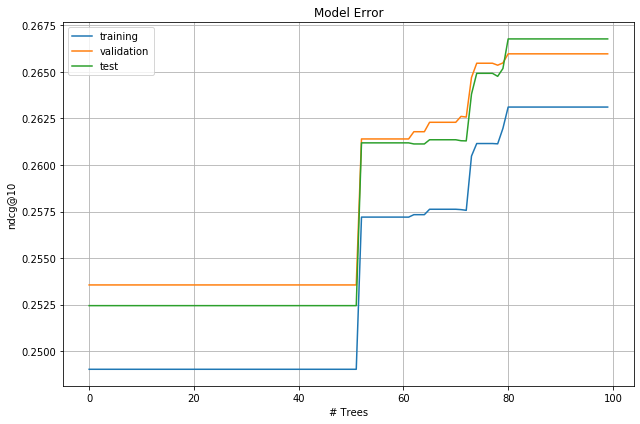

In [9]:
def evaluation(preds, train_data):
    global ds_to_queries
    #bz = eval_boltzrank(ds_to_queries[len(preds)][0], preds)
    labels = train_data.get_label()
    avg_mse = 0.5 * np.mean( (labels-preds)**2 )
    print("MSE eval: " + str(avg_mse))
    return 'MSE', avg_mse, False

def compute_grads(preds, train_data): 
    global ds_to_queries
    global train_id
    gain, hess = eval_boltzrank_grads(ds_to_queries[train_id][0], preds)
    gain = np.asarray(gain)
    hess = np.asarray(hess)
    #print("min " + str(np.min(gain)) + " max " + str(np.max(gain)) + " mean " + str(np.mean(gain)) + " std " + str(np.std(gain)))
    #print("preds " + str(preds))
    #print("gain " + str(gain))
    #print("hess " + str(hess))
    labels = train_data.get_label()
    avg_mse = 0.5 * np.mean( (labels-preds)**2 )
    print("MSE grads: " + str(avg_mse))
    return gain, hess

params = {
    'learning_rate': 0.1,
    'num_leaves': 16,
    'min_data_in_leaf': 5,
    'metric': ['ndcg'],# ['None']
    'ndcg_eval_at': 10
}    

print("training lightgbm...")
start = time.process_time()
lgbm_info = {}
lgbm_model = lightgbm.train(params, train_lgb, num_boost_round=100,
                            feval = evaluation,
                            fobj  = compute_grads,
                            valid_sets   = [train_lgb, valid_lgb, test_lgb], 
                            valid_names  = ["train", "valid", "test"],
                            evals_result = lgbm_info,
                            verbose_eval = 1)
print("training took " + str(time.process_time() - start) + " s")
print("done")

# Plot the results
plt.figure(figsize=(9,6), tight_layout=True)
plt.plot(lgbm_info['train'][METRIC_NAME], label='training')
plt.plot(lgbm_info['valid'][METRIC_NAME], label='validation')
plt.plot(lgbm_info['test'][METRIC_NAME], label='test')
plt.grid()
plt.legend()
plt.xlabel("# Trees")
plt.ylabel(METRIC_NAME)
plt.title("Model Error")

In [9]:
def check(q, k):
    indexes = set(range(0, len(q.perms)))
    indexes.remove(k)
    result = []
    for i in range(len(q.perms[k])):
        tmp = set(indexes)
        for j in tmp:
            if q.perms[k][i] != q.perms[j][i]:
                indexes.remove(j)
    for w in indexes:
        if w < k:
            result.append((w, k))
        else: 
            result.append((k,w))
    return result

def checkRepetitions():
    global queries
    same = dict()
    for q in queries.values():
        for i in range(len(q.perms)):
            r = check(q, i)
            if len(r) != 0:
                if not q.qid in same.keys():
                    same[q.qid] = set()
                for t in r:
                    same[q.qid].add(t)

    print(str(len(same.keys())) + "/" + str(len(queries.keys())) + " queries have duplicate permutations")
    for q, s in same.items():
        print("query " + str(q) + " has repeated permutations: " + str(s))
        
#checkRepetitions()            

In [10]:
freq = {}
for query in queries.values():
    for prob in query.probs:
        if not prob in freq.keys():
            freq[prob] = 0
        freq[prob] += 1

x = []
y = []
for prob, f in sorted(freq.items()):
    x.append(prob)
    y.append(f)
    
plt.figure(figsize=(9,6), tight_layout=True)
plt.plot(x, y, '.')
plt.grid()
plt.xlabel("probability")
plt.ylabel("# rank")
plt.yscale("log")
plt.title("probabilities of the " + str(totperms) + " permutations")

AttributeError: 'tuple' object has no attribute 'values'

In [ ]:
freq = {}
totperms = 0
for query in queries.values():
    for ndcg in query.ndcgs:
        totperms += 1
        if not ndcg in freq.keys():
            freq[ndcg] = 0
        freq[ndcg] += 1

x = []
y = []
for ndcg, f in sorted(freq.items()):
    x.append(ndcg)
    y.append(f)
    
plt.figure(figsize=(9,6), tight_layout=True)
plt.plot(x, y, '.')
plt.grid()
plt.xlabel("ndcg@10")
plt.ylabel("frequency")
plt.yscale("log")
plt.title("ndcg@10 frequencies over " + str(totperms) + " permutations")